<a href="https://colab.research.google.com/github/Joongeun/MIT-Internship-2024/blob/main/Web_Scraping_for_Climate_Feedback_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
def population(b, c, m1):
  a = [[0 for i in range(7)] for j in range(7)]
  for i in range(6):
    a[i][i+1] = b[i]
  for i in range(7):
    a[i][0] = c[i]
  a[-1][-1] = .4
  m2 = np.array(a)
  print(m2)
  ones = np.array([[1] for i in range(7)])
  for i in range(1, 21):
    m3 = np.matmul(m1, m2)
    m1 = m3
    if i in [5, 10, 20]:
      # print(i)
      print(np.matmul(m3, ones))
  # print("-"*10)
# # Spuds
# b = [0.2, 0.6, 0.2, 0, 0, 0]
# c = [0, 2, 4, 5, 0, 0, 0]
# m1 = np.array([25000, 35000, 40000, 40000, 45000, 35000, 40000])
# population(b, c, m1)
# # Locusts
# b = [0.03623, 0.1, 0.2, .1, 0, 0]
# c = [0, 0, 230, 230, 0, 0, 0]
# m1 = np.array([10000, 10000, 10000, 10000, 0, 0, 0])
# population(b, c, m1)
# #Mice
# b = [0.03, 0.08, 0.09, .1, 0.09, 0.09]
# c = [0, 30, 40, 50, 20, 2, 0]
# m1 = np.array([10000, 10000, 10000, 10000, 10000, 10000, 10000])
# population(b, c, m1)

# Spuds
b = [0.5, 0.5, 0.6, .6, 0.5, 0.5]
c = [0, 3, 3, 3, 3, 3, 1]
m1 = np.array([25000, 35000, 40000, 40000, 45000, 35000, 40000])
population(b, c, m1)
# Locusts
b = [0.1, 0.1, 0.2, 0, 0, 0]
c = [0, 0, 237, 237, 0, 0, 0]
m1 = np.array([10000, 10000, 10000, 10000, 0, 0, 0])
population(b, c, m1)
#Mice
b = [0.11, 0.15, 0.2, 0.3, 0.2, 0.1]
c = [0, 20, 30, 40, 50, 20, 2]
m1 = np.array([10000, 10000, 10000, 10000, 10000, 10000, 10000])
population(b, c, m1)

In [ ]:
!pip install requests
!pip install BeautifulSoup4

In [ ]:
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import csv
import time
import pandas as pd
from pprint import pprint

In [ ]:
import re
def preprocess(txt):
  txt = re.sub("\n", "", txt)
  if " \xa0 " in txt:
    txt = re.sub(" \xa0 ", "", txt)
  return txt

# Gathering 179 Posts on Climate Feedback Site


In [ ]:
pg_num = 1
claim, source, verdict, key_takeaway, review = [], [], [], [], []

for pg_num in range(1, 19): # Looping through pages 1-18
  url = f"https://climatefeedback.org/claim-reviews/{pg_num}/"
  html = requests.get(url)
  soup = BeautifulSoup(html.text, 'html.parser')
  # Extracts the claim & URL from the page
  info = soup.find_all("a", class_="strong")

  # Looping through each claim & URL
  for i in info:
    sub_url = i.attrs['href'] # Extracts the claim's URL
    html = requests.get(sub_url)
    soup = BeautifulSoup(html.text, 'html.parser')

    # Gets all text from "Review section" - ResultSet object with 1 element (all text) is returned (indexing works because it's similar to a list)
    info = soup.find_all("div", class_="entry-content")[0]

    # Get claim
    c = info.find("blockquote").get_text()[8:]
    claim.append(c)
    # print(claim)

    label = info.find("img", class_="fact-check-card__row__verdict__img").attrs['src']
    label = label.split("/")[-1].split("_")
    label = " ".join(label[1:]).split(".")[0]
    verdict.append(label)
    # print(label)

    # Gets "key takeaway" section text
    summary = soup.find("div", class_="fact-check-card__takeaway__text col-sm-10").get_text()
    summary = preprocess(summary)
    key_takeaway.append(summary)
    # print(key_takeaway)

    #Get Paragraphs
    paragraphs = info.find_all("p")
    paragraphs = [p.get_text() for p in paragraphs]
    # Get author, source, and post date of the claim in question
    s = paragraphs.pop(0)[9:]
    s = preprocess(s)
    source.append(s)
    # print(source)

    # Gets paragraph texts in the "Review" section only - (excludes some of the headings–e.x: "Conclusion" heading–and the entire References section)
    paragraphs = " ".join(paragraphs[1:])
    paragraphs = preprocess(paragraphs)
    review.append(paragraphs)
    # pprint(paragraphs)

    # Gets all the text in the "Review" section joined together (Includes the References)
    # selftext = paragraphs[0]
    # print(selftext)

cols = ["claim", "source", "verdict", "key_takeaway", "review"]
vals = [claim, source, verdict, key_takeaway, review]
d = {col:l for (col, l) in zip(cols, vals)}
df = pd.DataFrame(d)
df

,claim,source,verdict,key_takeaway,review
0,Ice cores from Greenland show no significant w...,"Stephen Andrews, Daily Sceptic, 8 Mar. 2024",Inaccurate,The effect of atmospheric CO2 concentrations o...,The consensus among climate scientists is that...
1,Arctic sea ice is not melting. There is no ind...,"Allan Astrup Jensen, The Epoch Times, 6 Feb. 2024",Incorrect,Despite short-term fluctuations due to natural...,"Since the 1970s, satellites have been providin..."
2,Increasing carbon dioxide (CO2) is not bad for...,"Jimmy Corsetti, Bright Insight, 4 Feb. 2024",Misleading,Elevated atmospheric-CO2 from human emissions ...,"During Earth’s 4.5 billion year history, the a..."
3,New study and article headline saying homegrow...,"Social media users, Facebook, The Atlas Societ...",Misleading,Although low-tech urban agriculture is expecte...,"To meet global food challenges, such as increa..."
4,There are secret government programs using che...,"Social media users, Facebook, YouTube, 12 Jan....",Inaccurate,Contrails are trails of condensing water vapor...,"There is no credible, scientific evidence that..."
...,...,...,...,...,...
174,Stunning new data indicates El Niño drove reco...,"David Rose, Daily Mail, 26 Nov. 2016",Misleading,The continuing rise of global temperature is m...,"Zeke Hausfather, Director of Climate and Ener..."
175,Increased atmospheric carbon dioxide has helpe...,"Harrison Schmitt, Rodney Nichols, The Wall Str...",Unsupported,Continued CO2 emissions will not improve futur...,"Wolfgang Cramer, Professor, Directeur de Rech..."
176,"Sea level rise, which was occurring long befor...","Roy Spencer, Forbes, 25 Oct. 2016",Inaccurate,Continuing warming causes an accelerating rise...,"Benjamin Horton, Professor, Earth Observatory..."
177,"In 2013, scientists reached a consensus that t...","Justin Gillis, The New York Times, 3 Sept. 2016",Correct,Continuing greenhouse gas emissions growth cou...,"Benjamin Horton, Professor, Earth Observatory..."


In [ ]:
with open('climate_feedback.csv', 'a') as f:
  writer = csv.writer(f)
  writer.writerow(cols)
  for i in range(len(df)):
    writer.writerow(list(df.iloc[i]))

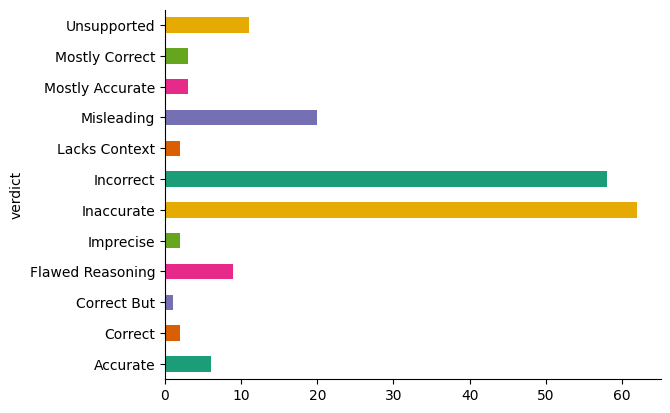

In [ ]:
# @title verdict

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('verdict').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)